In [181]:
import networkx as nx
import matplotlib.pyplot as plt

In [182]:
import matplotlib.cm as cm  # Para usar una paleta de colores continua
from networkx.drawing.nx_agraph import graphviz_layout

def mostrar_grafo(G):
    plt.figure(figsize=(10,10))  
    # Obtener todos los valores de profundidad para ajustar el rango de colores
    profundidades = [G.nodes[node].get('profundidad', 0) for node in G.nodes]
    
    # Normalizar las profundidades para asignar colores continuos en una escala
    min_prof, max_prof = min(profundidades), max(profundidades)
    colors = [
        cm.viridis((prof - min_prof) / (max_prof - min_prof)) if max_prof > min_prof else cm.viridis(0.5)
        for prof in profundidades
    ]
    
    nx.draw(G,with_labels=False, node_color=colors, edge_color="gray", node_size=2000, font_size=10)
    # Prepara las etiquetas con atributos de cada nodo
    labels = {node: f"n:{node}\np:{G.nodes[node].get('profundidad', '')}" for node in G.nodes}
    
    # Dibuja las etiquetas de los nodos con sus atributos
    nx.draw_networkx_labels(G, labels, font_size=15, font_color="white")
    
    plt.margins(0.2)
    plt.show()

In [183]:
def describir_arbol(G):
    def describir_arbol_aux(nodo, G, profundidad):
        hijos = list(G.successors(nodo))
        resultado = "\t"*profundidad+f"Nodo: {nodo} | Profundidad: {G.nodes[nodo]['profundidad']}\n"
        if hijos != []:
            for hijo in hijos:
                resultado+=describir_arbol_aux(hijo,G,profundidad+1)
        return resultado
    nodes = list(G.nodes)
    string = describir_arbol_aux(nodes[0],G,0)
    print(string)

In [184]:
def hojas_preorden(G):
    hojas = {n for n, out_d in G.out_degree() if out_d == 0}
    recorrido_preorden = list(nx.dfs_preorder_nodes(G, source=1))
    lista_hojas = [nodo for nodo in recorrido_preorden if nodo in hojas]
    return lista_hojas

#### Creación del grafo simultánea.
Al crear el grafo simultáneamente, se aprovecha la estructura del árbol para formarlo. Cada vez que el algoritmo de space partitioning selecciona un nodo y crea sus hijos en el árbol, se crean en esa misma iteración del bucle las conexiones de los nuevos nodos entre sí. Una vez esas conexiones están creadas, se conectan los nuevos nodos con las capas superiores:
> Si su padre tuvo hermanos('contiguos' != []), se conectan los hijos adyacentes a los hermanos con estos últimos, añadiendo también esta conexión al parámetro contiguos para conexiones más complejas en las que la diferencia de profundidad sea mayor que 1.
Problema: No se puede limitar la conexión de los hijos de diferentes nodos en el mismo nivel. Al ser "heredado" el atributo 'contiguos', se hereda la conexión con ambos nodos de abajo, cuando los nodos hijo estarían conectados con un solo nodo cada uno.

In [185]:
import random

def formar_particion_estado_4(n, d=5, semilla = None):
    
    # Para conseguir reproducibilidad, podemos introducir una semilla al algoritmo.
    if semilla is not None:
        random.seed(semilla)
    else:
        # Generar una seed aleatoria y almacenarla
        semilla = random.randint(0, 2**32 - 1)
        random.seed(semilla)  # Establecer la seed
    
    lista_hojas = []
        
    A = nx.DiGraph()
    A.add_node(1, profundidad=0)
    A.graph['altura'] = 0
    
    lista_hojas.append(1)
    nodos=1
    
    for i in range(1,n+1):
        if lista_hojas:
            #print(f"{i}: {lista_hojas}")
            selec = random.choice(lista_hojas)
            profundidad = nx.shortest_path_length(A, source=1,target=selec)+1
    
            if profundidad > A.graph['altura']:
                A.graph['altura'] = profundidad
            
            A.add_node(nodos+1,profundidad=profundidad)
            A.add_node(nodos+2,profundidad=profundidad)
            A.add_node(nodos+3,profundidad=profundidad)
            A.add_node(nodos+4,profundidad=profundidad)
            A.add_edges_from([(selec,nodos+1),(selec,nodos+2),(selec,nodos+3),(selec,nodos+4)])
            #print("Añadidos hijos "+str(nodos+1)+" y "+str(nodos+2))
            for i in range(1,5):
                profundidad = nx.shortest_path_length(A, source=1,target=nodos+i)+1
                if profundidad < d:
                    lista_hojas.append(nodos+i)
            
            lista_hojas.remove(selec)
            
            nodos+=4
    return A, semilla

In [186]:
import matplotlib.patches as patches
import os

class Cuadrado():
    def __init__(self, G, nodo=1, centro=None, tamaño=10, semilla = None):
        
        # Para conseguir reproducibilidad, podemos introducir una semilla al algoritmo.
        if semilla is not None:
            random.seed(semilla)
        else:  
            # Generar una seed aleatoria y almacenarla
            semilla = random.randint(0, 2**32 - 1)
            random.seed(semilla)  # Establecer la seed
        
        self.G=G
        self.S = nx.Graph()
        self.nodo = nodo
        self.tamaño = tamaño
        if centro is None:
            self.centro = (self.tamaño/2,self.tamaño/2)
        else:
            self.centro=centro
        self.tipo = 'pared'
        self.semilla = semilla
        self.nsalas = 0
        

        self.profundidad = self.G.graph['altura']
        
        # limites = [arriba,derecha,abajo,izquierda]
        offset = self.tamaño/2
        self.limites = [
            self.centro[1]+offset,
            self.centro[0]+offset,
            self.centro[1]-offset,
            self.centro[0]-offset
        ]

        self.cuadrantes = []
        self.hijos = []

        hijos = list(self.G.successors(nodo))

        if hijos:
            # Se divide por cuatro porque tiene la mitad de tamaño, y después se divide a la mitad otra vez para determinar el centro.
            mitad_tamaño = self.tamaño / 2
            centro_cuadrante = mitad_tamaño / 2
            offsets = [
                (-centro_cuadrante, centro_cuadrante),  # Cuadrante arriba izquierda
                (centro_cuadrante, centro_cuadrante),  # Cuadrante arriba derecha
                (-centro_cuadrante, -centro_cuadrante),  # Cuadrante abajo izquierda
                (centro_cuadrante, -centro_cuadrante)  # Cuadrante abajo derecha
            ]

            for hijo, offset in zip(hijos, offsets):
                nuevo_centro = (self.centro[0] + offset[0], self.centro[1] + offset[1])
                self.cuadrantes.append(Cuadrado(self.G, hijo, nuevo_centro, mitad_tamaño))
                
    def __str__(self):
        """
        Representación en texto del cuadrado.
        """
        return f"Cuadrado(nodo={self.nodo},tipo={self.tipo},límites={self.limites})"
            
    def formar_grafo(self):
        lista_hojas = self.hojas_preorden()
        for i in lista_hojas:
            #print(lista_hojas)
            yo = self.encontrar_cuadrante(i)
            #print(f"Hoja {yo.nodo}")
            if yo.nodo not in self.S.nodes:
                self.S.add_node(yo.nodo)
                self.S.nodes[yo.nodo]['arriba'] = []
                self.S.nodes[yo.nodo]['derecha'] = []
                self.S.nodes[yo.nodo]['izquierda'] = []
                self.S.nodes[yo.nodo]['abajo'] = []
                self.S.nodes[yo.nodo]['tamaño'] = self.profundidad - self.G.nodes[yo.nodo]['profundidad']
                
            for j in lista_hojas:
                tu = self.encontrar_cuadrante(j)
                #print(f"\tHoja {tu.nodo}")
                
                if tu.nodo not in self.S.nodes:
                    self.S.add_node(tu.nodo)
                    self.S.nodes[tu.nodo]['arriba'] = []
                    self.S.nodes[tu.nodo]['derecha'] = []
                    self.S.nodes[tu.nodo]['izquierda'] = []
                    self.S.nodes[tu.nodo]['abajo'] = []
                    self.S.nodes[tu.nodo]['tamaño'] = self.profundidad - self.G.nodes[tu.nodo]['profundidad']
                
                if i == j:
                    #print("Comparación de iguales")
                    continue
                
                # Conexión hacia arriba
                if yo.limites[0] == tu.limites[2]:
                    #print("\tLimites superior e inferior coinciden.")
                    if yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['arriba']:
                            self.S.nodes[yo.nodo]['arriba'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['abajo']:
                            self.S.nodes[tu.nodo]['abajo'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                
                # Conexión hacia la derecha
                if yo.limites[1] == tu.limites[3]:
                    #print("\tLimites derecha e izquierda coinciden.")
                    if yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['derecha']:
                            self.S.nodes[yo.nodo]['derecha'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['izquierda']:
                            self.S.nodes[tu.nodo]['izquierda'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                        
                # Conexión hacia abajo
                if yo.limites[2] == tu.limites[0] :
                    #print("\tLimites superior e inferior coinciden.")
                    if yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['abajo']:
                            self.S.nodes[yo.nodo]['abajo'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['arriba']:
                            self.S.nodes[tu.nodo]['arriba'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                        
                # Conexión hacia la izquierda
                if yo.limites[3] == tu.limites[1]:
                    #print("\tLimites derecha e izquierda coinciden.")
                    if yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['izquierda']:
                            self.S.nodes[yo.nodo]['izquierda'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['derecha']:
                            self.S.nodes[tu.nodo]['derecha'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                
    def encontrar_cuadrante(self, id):
        """
        Busca el cuadrante que contiene el nodo con el ID especificado.
        Imprime un mensaje si no lo encuentra y detiene la búsqueda.
        """
        if self.nodo == id:
            #print(f"Nodo encontrado: {self.nodo}")
            return self
    
        for cuadrante in self.cuadrantes:
            resultado = cuadrante.encontrar_cuadrante(id)
            if resultado:
                return resultado
            
        return None
            
    def hojas_preorden(self):
        hojas = {n for n, out_d in self.G.out_degree() if out_d == 0}
        recorrido_preorden = list(nx.dfs_preorder_nodes(self.G, source=1))
        return [nodo for nodo in recorrido_preorden if nodo in hojas]
    
    def crear_mazmorra_clasica(self, n=5):
        # TODO: prohibir también las diagonales como suelos adyacentes.
        # TODO: ¿Que encuentre el máximo de salas posibles o darle el número? Ver apuntes Formar mazmorra 31/1/25
        # TODO: Nodos de tamaño 1 también?
        
        lista_hojas = self.hojas_preorden()
        nodos = self.S.nodes
        max_intentos = 50
        
        lista_salas = []
        
        for i in range(n):
            intentos = 0
            while True:
                if lista_hojas:
                    selec = random.choice(lista_hojas)
                else:
                    intentos=max_intentos+1
                tamaño = nodos[selec]['tamaño']
                nodo_selec = self.encontrar_cuadrante(selec)
                print(f"Evaluando nodo {selec} de tipo {nodo_selec.tipo} y tamaño {tamaño}")
                
                print("Evaluación de adyacentes:")
                conectado = self.comprobar_adyacentes(selec)
                
                print(f"¿Es {nodo_selec.tipo} suelo?")
                if nodo_selec.tipo != 'suelo':
                    print("No")
                    print(f"¿Es {conectado} True?")
                    if not conectado:
                        print("No")
                        break
                print("Si") 
                intentos += 1
                if selec in lista_hojas:
                    lista_hojas.remove(selec)
                if intentos >= max_intentos:
                    print("Límite alcanzado")
                    break
                    
            print(f"SELECCIONADO {selec}\n")
            nodo_selec.tipo = 'suelo'
            if i != 0:
                print(i)
                
            
    def comprobar_adyacentes(self, nodo):
        for nodo in list(self.S.neighbors(nodo)):
            cuadrante = self.encontrar_cuadrante(nodo)
            print(f"\tEvaluando {nodo} ")
            if cuadrante.tipo == 'suelo':
                print(f"\t\tSuelo")
                return True
        return False
    
    def MAL(self, n = 5):
        # TODO: Este método no debe poder seleccionar nodos que ya sean suelo, ni expandirse hacia otra sala.
        # TODO: Terminar prints de selección.
        # TODO: Pasillos.
        # TODO: Selección informada de puntos de sala.
        # TODO: Generalización de expansiones para variar profundidad deseada.
        
        self.nsalas = n
        lista_hojas = self.hojas_preorden()
        nodos = self.S.nodes        
        
        for i in range(n):
            direcciones = []
            transformar = []
            expansion = []
            selec = random.choice(lista_hojas)
            tamaño = nodos[selec]['tamaño']
            nodo_selec = self.encontrar_cuadrante(selec)
            while nodo_selec.tipo == 'suelo':
                selec = random.choice(lista_hojas)
                tamaño = nodos[selec]['tamaño']
                nodo_selec = self.encontrar_cuadrante(selec)
            print(f"Nodo seleccionado: {selec} de tamaño {tamaño}")
            
            if tamaño == 0:
                # Se obtienen las direcciones hacia las que se puede expandir y se almacenan en 'direcciones'
                for attr in nodos[selec]:
                    if attr != 'tamaño':
                        for nodo in nodos[selec][attr]:
                            if nodos[nodo]['tamaño'] == 0:
                                direcciones.append(attr)
                
                # Los nodos de las esquinas se almacenan en la lista esquinas, en el orden mostrado.
                esquinas = []
                
                # En el caso de que se pueda realizar una expansión en las 4 direcciones, podemos formar un cuadrado 3x3...
                if all(direc in direcciones for direc in ['arriba', 'derecha', 'izquierda', 'abajo']):
                    # Esquina arriba-derecha
                    esquinas.append(nodos[nodos[selec]['arriba'][0]]['derecha'][0])
                    # Esquina derecha-abajo
                    esquinas.append(nodos[nodos[selec]['derecha'][0]]['abajo'][0])
                    # Esquina abajo-izquierda
                    esquinas.append(nodos[nodos[selec]['abajo'][0]]['izquierda'][0])
                    # Esquina izquierda-arriba
                    esquinas.append(nodos[nodos[selec]['izquierda'][0]]['arriba'][0])
                    
                
                    
                    # ...solo en el caso en el que las esquinas sean de tamaño mínimo.
                    if all(nodos[nodo]['tamaño'] == 0 for nodo in esquinas):
                        # Cuando se cumplen esas condiciones, se añaden a la lista transformar el centro, los contiguos y las esquinas, formando un cuadrado 3x3.
                        transformar.append(selec)
                        transformar += [
                            nodos[selec]['arriba'][0],
                            nodos[selec]['derecha'][0],
                            nodos[selec]['abajo'][0],
                            nodos[selec]['izquierda'][0]
                        ]
                        transformar += esquinas
                        print("Cuadrado 3x3 posible.")
                
                # Para evitar el caso en el que si que hayan expansiones en las 4 direcciones (por lo que entraría en el if anterior), pero alguna de las esquinas no sea de tamaño mínimo, se usa la lista 'transformar', inicializada en vacía y solo llena si puede realizarse el cuadrado 3x3, como una flag para detectar la alternativa en la que se debe realizar un cuadrado 2x2.
                # Cuando 'transformar' está vacío y existen direcciones en las que expandir y...
                if not transformar and direcciones:
                    # ...existe la combinación "arriba-derecha",...
                    if all(direc in direcciones for direc in ['arriba','derecha']):
                        if nodos[nodos[nodos[selec]['arriba'][0]]['derecha'][0]]['tamaño'] == 0:    # Nodo arriba-derecha
                            print("Posible cuadrado 2x2 arriba-derecha.")
                            expansion.append("arriba-derecha")
                    # ...existe la combinación "derecha-abajo",...
                    if all(direc in direcciones for direc in ['derecha','abajo']):
                        if nodos[nodos[nodos[selec]['derecha'][0]]['abajo'][0]]['tamaño'] == 0:     # Nodo derecha-abajo
                            print("Posible cuadrado 2x2 derecha-abajo.")
                            expansion.append("derecha-abajo")
                    # ...existe la combinación "abajo-izquierda",...
                    if all(direc in direcciones for direc in ['abajo','izquierda']):
                        if nodos[nodos[nodos[selec]['abajo'][0]]['izquierda'][0]]['tamaño'] == 0:   # Nodo abajo-izquierda
                            print("Posible cuadrado 2x2 abajo-izquierda.")
                            expansion.append("abajo-izquierda")
                    # ...existe la combinación "izquierda-arriba",...
                    if all(direc in direcciones for direc in ['izquierda','arriba']):
                        if nodos[nodos[nodos[selec]['izquierda'][0]]['arriba'][0]]['tamaño'] == 0:  # Nodo izquierda-arriba
                            print("Posible cuadrado 2x2 izquierda-arriba.")
                            expansion.append("izquierda-arriba")
                    
                    # ...se elige una de las expansiones 2x2.
                    expando = random.choice(expansion)
                    if expando == "arriba-derecha":
                        print(f"Seleccionada expansión en la dirección: {expando}")
                        transformar.append(selec)
                        transformar += [
                            nodos[selec]['arriba'][0],
                            nodos[selec]['derecha'][0],
                            nodos[nodos[selec]['arriba'][0]]['derecha'][0]      # Nodo arriba-derecha
                        ]
                    elif expando == "derecha-abajo":
                        print(f"Seleccionada expansión en la dirección: {expando}")
                        transformar.append(selec)
                        transformar += [
                            nodos[selec]['derecha'][0],
                            nodos[selec]['abajo'][0],
                            nodos[nodos[selec]['derecha'][0]]['abajo'][0]       # Nodo derecha-abajo
                        ]
                    elif expando == "abajo-izquierda":
                        print(f"Seleccionada expansión en la dirección: {expando}")
                        transformar.append(selec)
                        transformar += [
                            nodos[selec]['abajo'][0],
                            nodos[selec]['izquierda'][0],
                            nodos[nodos[selec]['abajo'][0]]['izquierda'][0]     # Nodo abajo-izquierda
                        ]
                    elif expando == "izquierda-arriba":
                        print(f"Seleccionada expansión en la dirección: {expando}")
                        transformar.append(selec)
                        transformar += [
                            nodos[selec]['izquierda'][0],
                            nodos[selec]['arriba'][0],
                            nodos[nodos[selec]['izquierda'][0]]['arriba'][0]    # Nodo izquierda-arriba
                        ]
    
            elif tamaño == 1:
                # Se obtienen las direcciones en las que se puede expandir, es decir, las direcciones en las que los nodos contiguos son 2 de un tamaño menor.
                for attr in nodos[selec]:
                    if attr != 'tamaño':
                        posible = 0
                        # Si en esa dirección el cuadrante contiguo tiene exactamente un tamaño menos...
                        for nodo in nodos[selec][attr]:
                            if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']-1:
                                posible+=1
                        # ...y hay dos de estos cuadrantes contiguos en esa dirección, es posible expandir hacia ahí.
                        if posible == 2:
                            direcciones.append(attr)
                # En 'direcciones' tenemos almacenadas las direcciones hacia las que este cuadrante de tamaño 1 tiene 2 cuadrantes de tamaño 0 contiguos.
                
                # Una vez tenemos las direcciones a las que podemos expandir...
                
                if len(direcciones)>1:
                    # ...comprobamos las esquinas por pares.
                    arriba = nodos[selec]['arriba']
                    abajo = nodos[selec]['abajo']
                    # Si existe posibilidad de un cuadrado 3x3 hacia arriba-derecha...
                    if all(direc in direcciones for direc in ['arriba','derecha']):
                        print("Comprobando arriba-derecha...")
                        # Por los nombres asignados a los hijos de un nodo en el árbol: 
                        # Al partir el espacio, quedan los nodos con mayor índice en los cuadrantes inferiores.
                        # De estos cuadrantes inferiores, el cuadrante de más a la derecha siempre será el de mayor índice.
                        esquinaArDe = nodos[max(arriba)]['derecha'][0] # [0]: por el límite de profundidad un nodo de tamaño 0 puede estar en contacto con un nodo en cada dirección, ya que es el tamaño mínimo.
                        # Comprobamos si la esquina tiene un tamaño mínimo. Cuando se cumpla esta condición, tenemos un cuadrado 3x3 posible.
                        if nodos[esquinaArDe]['tamaño'] == nodos[selec]['tamaño']-1:
                            print("Cuadrado válido hacia arriba-derecha")
                            expansion.append("arriba-derecha")
                            
                    # Si existe posibilidad de un cuadrado 3x3 hacia derecha-abajo...
                    if all(direc in direcciones for direc in ['derecha','abajo']):
                        print("Comprobando derecha-abajo...")        
                        # Por los nombres asignados a los hijos de un nodo en el árbol: 
                            # Al partir el espacio, quedan los nodos con menor índice en los cuadrantes superiores.
                            # De estos cuadrantes superiores, el cuadrante de más a la derecha siempre será el de mayor índice.
                        esquinaAbDe = nodos[max(abajo)]['derecha'][0] # [0]: por el límite de profundidad un nodo de tamaño 0 puede estar en contacto con un nodo en cada dirección, ya que es el tamaño mínimo.
                        # Comprobamos si la esquina tiene un tamaño mínimo. Cuando se cumpla esta condición, tenemos un cuadrado 3x3 posible.
                        if nodos[esquinaAbDe]['tamaño'] == nodos[selec]['tamaño']-1:
                            print("Cuadrado válido hacia derecha-abajo")
                            expansion.append("derecha-abajo")
                            
                    # Si existe posibilidad de un cuadrado 3x3 hacia abajo-izquierda...
                    if all(direc in direcciones for direc in ['abajo','izquierda']):
                        print("Comprobando abajo-izquierda...")
                        # Por los nombres asignados a los hijos de un nodo en el árbol: 
                            # Al partir el espacio, quedan los nodos con menor índice en los cuadrantes superiores.
                            # De estos cuadrantes superiores, el cuadrante de más a la izquierda siempre será el de menor índice.
                        esquinaAbIz = nodos[min(abajo)]['izquierda'][0] # [0]: por el límite de profundidad un nodo de tamaño 0 puede estar en contacto con un nodo en cada dirección, ya que es el tamaño mínimo.
                        # Comprobamos si la esquina tiene un tamaño mínimo. Cuando se cumpla esta condición, tenemos un cuadrado 3x3 posible.
                        if nodos[esquinaAbIz]['tamaño'] == nodos[selec]['tamaño']-1:
                            print("Cuadrado válido hacia abajo-izquierda")
                            expansion.append("abajo-izquierda")
                            
                    # Si existe posibilidad de un cuadrado 3x3 hacia izquierda-arriba...
                    if all(direc in direcciones for direc in ['izquierda','arriba']):
                        print("Comprobando izquierda-arriba...")      
                        # Por los nombres asignados a los hijos de un nodo en el árbol: 
                            # Al partir el espacio, quedan los nodos con mayor índice en los cuadrantes inferiores.
                            # De estos cuadrantes inferiores, el cuadrante de más a la izquierda siempre será el de menor índice.
                        esquinaIzAr = nodos[min(arriba)]['izquierda'][0]# [0]: por el límite de profundidad un nodo de tamaño 0 puede estar en contacto con un nodo en cada dirección, ya que es el tamaño mínimo.    
                        # Comprobamos si la esquina tiene un tamaño mínimo. Cuando se cumpla esta condición, tenemos un cuadrado 3x3 posible.
                        if nodos[esquinaIzAr]['tamaño'] == nodos[selec]['tamaño']-1:
                            print("Cuadrado válido hacia izquierda-arriba")
                            expansion.append("izquierda-arriba")
                    
                    # Se selecciona una de las expansiones 3x3 posibles...
                    # Puede ocurrir que se llegue aquí teniendo como posibles expansiones direcciones opuestas. Es por esto que se comprueba si expansión está vacío antes de realizar la expansión
                    if expansion:
                        expando = random.choice(expansion)
                        # ...y se añaden a 'transformar' los cuadrantes que conforman el 3x3.
                        if expando == "arriba-derecha":
                            print(f"Seleccionada expansión en la dirección: {expando}")
                            transformar.append(selec)
                            transformar += nodos[selec]['arriba'] + nodos[selec]['derecha']
                            transformar.append(esquinaArDe)
                            
                        elif expando == "derecha-abajo":
                            print(f"Seleccionada expansión en la dirección: {expando}")
                            transformar.append(selec)
                            transformar += nodos[selec]['derecha'] + nodos[selec]['abajo']
                            transformar.append(esquinaAbDe)
                            
                        elif expando == "abajo-izquierda":
                            print(f"Seleccionada expansión en la dirección: {expando}")
                            transformar.append(selec)
                            transformar += nodos[selec]['abajo'] + nodos[selec]['izquierda']
                            transformar.append(esquinaAbIz)
                            
                        elif expando == "izquierda-arriba":
                            print(f"Seleccionada expansión en la dirección: {expando}")
                            transformar.append(selec)
                            transformar += nodos[selec]['izquierda'] + nodos[selec]['arriba']
                            transformar.append(esquinaIzAr)
                                    
                # En caso de no haber ningún cuadrado 3x3 posible, pero sí haber expansiones 3x2 posibles...
                # Se usa la lista 'transformar' como flag para comprobar si aún no se ha seleccionado una agrupación de cuadrantes.
                if not transformar and direcciones:
                    # Se escoge una dirección aleatoria de las posibles y se añaden a la lista los cuadrantes relevantes.
                    transformar.append(selec)
                    transformar += nodos[selec][random.choice(direcciones)]
                
                # En caso de que no haya ninguna expansión posible, se usa el cuadrante como suelo sin expandir.
                if not transformar:
                    transformar.append(selec)
                    
            elif tamaño == 2:
                # Para cada dirección posible desde el nodo seleccionado...
                for attr in nodos[selec]:
                    if attr != 'tamaño':
                        posible = 0
                        # ...si en esa dirección el cuadrante contiguo tiene exactamente un tamaño menos...
                        for nodo in nodos[selec][attr]:
                            if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']-1:
                                posible+=1
                        # ...y hay dos de estos cuadrantes contiguos, es posible expandir en esa dirección
                        if posible == 2:
                            direcciones.append(attr)
                
                # Si existen expansiones posibles...
                if direcciones:
                    # ...se escoge una de las direcciones posibles de forma aleatoria.
                    expandir = random.choice(direcciones)
                    # Se añaden los nodos que forman este 6x4 a 'transformar'
                    transformar.append(selec)
                    transformar += nodos[selec][expandir]
                
                # En el caso en el que no hayan expansiones posibles, el nodo seleccionado se convierte en una sala por sí mismo.
                if not transformar:
                    transformar.append(selec)
                    
            elif tamaño == 3:
                # Se crea una sala con exclusivamente este cuadrante.
                transformar.append(selec)
                
            for nodo in transformar:
                lista_hojas.remove(nodo)
                cuadrante = self.encontrar_cuadrante(nodo)
                cuadrante.tipo = 'suelo'
    
    def crear_mazmorra_dikjstra(self, n = 5):
        pintados = []
        lista_hojas = self.hojas_preorden()
        print(f"Lista de hojas: {lista_hojas}")
        
        inicio = random.choice(lista_hojas)
        fin = random.choice(lista_hojas)
        while inicio == fin:
            fin = random.choice(lista_hojas)
        
        print(f"Camino de {inicio} a {fin}:")
        camino = nx.shortest_path(self.S, source = inicio, target = fin)
        print(camino)
        
        for nodo in camino:
            pintados.append(nodo)
            print(f"\tNodo: {nodo} pintado")
            cuadrante = self.encontrar_cuadrante(nodo)
            cuadrante.tipo='suelo'
            
        for i in range(n-1):
            inicio = random.choice(lista_hojas)
            fin = random.choice(pintados)
            while inicio == fin:
                fin = random.choice(pintados)
            
            print(f"Camino de {inicio} a {fin}:")
            camino = nx.shortest_path(self.S, source = inicio, target = fin)
            print(camino)
            
            for nodo in camino:
                print(f"\tNodo: {nodo} pintado")
                cuadrante = self.encontrar_cuadrante(nodo)
                cuadrante.tipo='suelo'

    def imprimir_estructura(self, nivel=0):
        """
        Imprime la estructura jerárquica del cuadrado.
        """
        print(" " * nivel * 4 + str(self))
        for cuadrante in self.cuadrantes:
            cuadrante.imprimir_estructura(nivel + 1)
            
    def dibujar_grafo(self):
        """ Dibuja el grafo de conectividad de las salas """
        pos = {nodo: (self.encontrar_cuadrante(nodo).centro) for nodo in self.S.nodes}
        
        plt.figure(figsize=(self.tamaño, self.tamaño))
        nx.draw(self.S, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="grey")
        plt.show()
    
    def dibujar(self, guardar = False):   
        
        def dibujar_aux(raiz, ax, transparente):
            if not raiz.cuadrantes:
                # Dibuja el cuadrado actual
                x, y = raiz.centro
                tamaño = raiz.tamaño
                
                colores = {
                    'pared': 'black',
                    'suelo': 'white',
                    'borde': ('grey' if transparente else 'None')
                }
                    
                rect = patches.Rectangle(
                    (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                    linewidth=1, edgecolor=colores['borde'], facecolor=colores[raiz.tipo]
                )
                ax.add_patch(rect)
                
                if transparente:
                    ax.text(x, y, str(raiz.nodo), color='grey', fontsize=raiz.tamaño*5, ha='center', va='center')
    
            # Dibujar los hijos
            for cuadrante in raiz.cuadrantes:
                dibujar_aux(cuadrante,ax,transparente)
                
        fig, (ax1, ax2) = plt.subplots(figsize=(self.tamaño*2, self.tamaño),ncols=2)
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(.2)  # Fondo de la figura transparente
        
        for ax,transparente in [(ax1,True),(ax2,False)]:
            ax.set_xlim(0, self.tamaño)
            ax.set_ylim(0, self.tamaño)
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title(str(self.semilla))
            dibujar_aux(self,ax,transparente)
        
        if guardar:
            carpeta = f"Cuadrados"
            if not os.path.exists(carpeta):
                os.makedirs(carpeta)
            
            # Guardar la figura en la carpeta con el nombre basado en la semilla
            archivo_guardado = os.path.join(
                carpeta, 
                f"figura_{self.semilla}_SpacePart_{self.nsalas}.svg"
            )
            fig.savefig(archivo_guardado, transparent=False, bbox_inches='tight')
            
            print(f"Figura guardada en: {archivo_guardado}")
         
        

In [187]:
def crear_mazmorra_space_part(arquitectura, npart = 20, prof = 5, nsalas = 5, guardar = False):
    A, semilla = formar_particion_estado_4(npart, d = prof)
    cuadrado = Cuadrado(A,semilla=semilla)
    #cuadrado.imprimir_estructura()
    cuadrado.formar_grafo()
    cuadrado.dibujar_grafo()
    cuadrado.crear_mazmorra_clasica(nsalas)   
    cuadrado.dibujar(guardar=guardar)
    return cuadrado

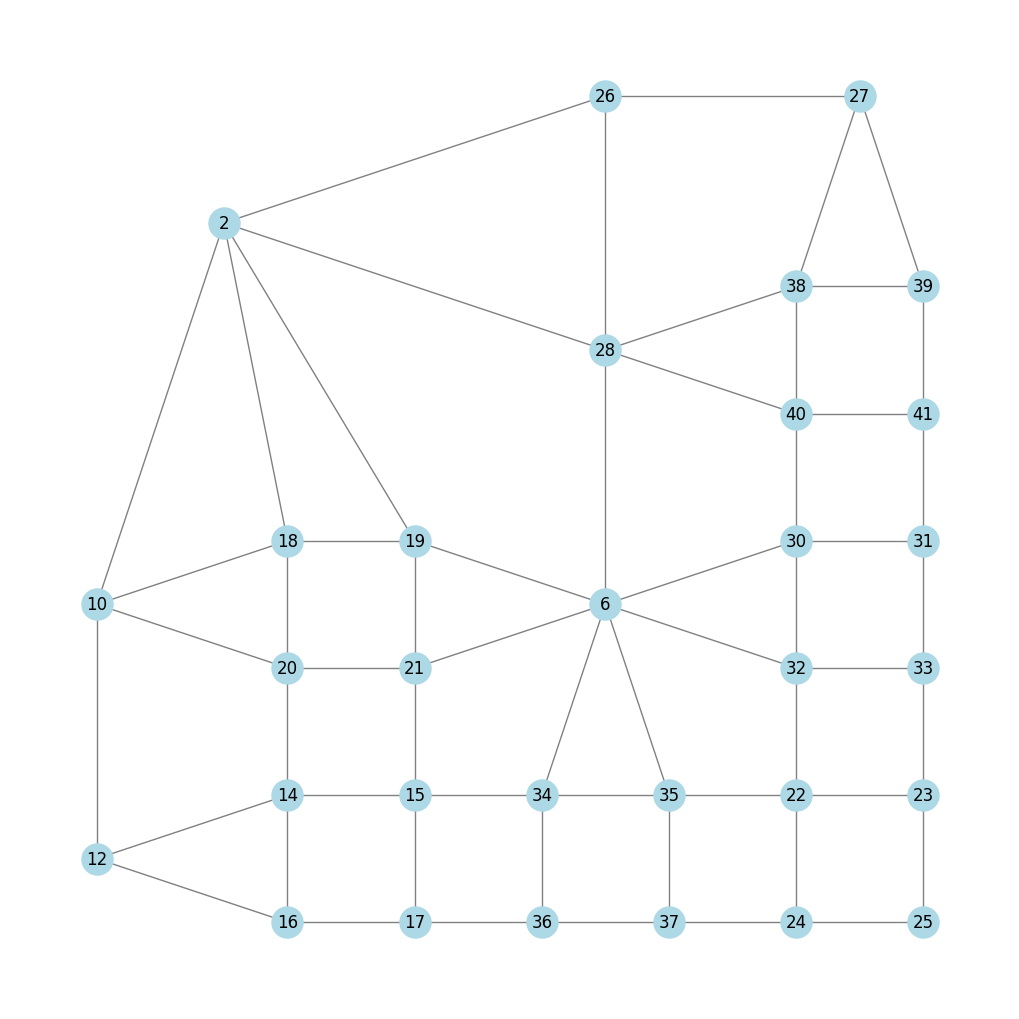

Evaluando nodo 20 de tipo pared y tamaño 0
Evaluación de adyacentes:
	Evaluando 18 
	Evaluando 10 
	Evaluando 21 
	Evaluando 14 
¿Es pared suelo?
No
¿Es False True?
No
SELECCIONADO 20

Evaluando nodo 28 de tipo pared y tamaño 1
Evaluación de adyacentes:
	Evaluando 26 
	Evaluando 2 
	Evaluando 6 
	Evaluando 38 
	Evaluando 40 
¿Es pared suelo?
No
¿Es False True?
No
SELECCIONADO 28

1
Evaluando nodo 17 de tipo pared y tamaño 0
Evaluación de adyacentes:
	Evaluando 15 
	Evaluando 16 
	Evaluando 36 
¿Es pared suelo?
No
¿Es False True?
No
SELECCIONADO 17

2
Evaluando nodo 6 de tipo pared y tamaño 1
Evaluación de adyacentes:
	Evaluando 28 
		Suelo
¿Es pared suelo?
No
¿Es True True?
Si
Evaluando nodo 15 de tipo pared y tamaño 0
Evaluación de adyacentes:
	Evaluando 21 
	Evaluando 14 
	Evaluando 17 
		Suelo
¿Es pared suelo?
No
¿Es True True?
Si
Evaluando nodo 19 de tipo pared y tamaño 0
Evaluación de adyacentes:
	Evaluando 2 
	Evaluando 18 
	Evaluando 21 
	Evaluando 6 
¿Es pared suelo?
No
¿Es Fal

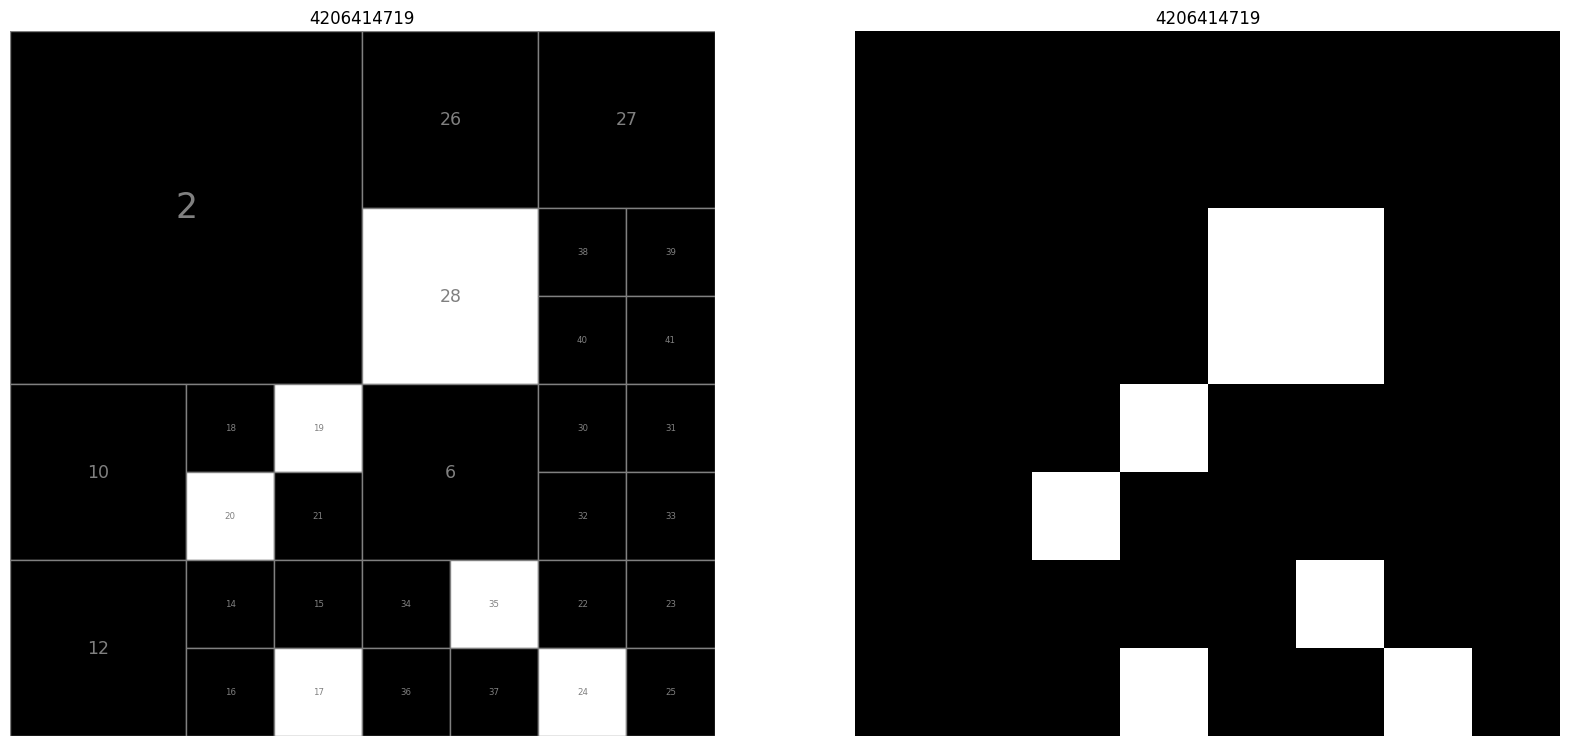

In [188]:
arquitectura = 'clasica'
npart = 10
prof = 4
nsalas = 6
guardar = False

cuadrado=crear_mazmorra_space_part(
    arquitectura=arquitectura, 
    npart=npart,
    prof=prof,
    nsalas=nsalas,
    guardar=guardar
)

In [205]:
nodos = cuadrado.S.nodes
selec = 35
direcciones = []
expansion = []

# TODO: comprobar que la expansión no colisione con otras salas

# Se obtienen las direcciones hacia las que se puede expandir y se almacenan en 'direcciones'
for attr in nodos[selec]:
    if attr != 'tamaño':
        for nodo in nodos[selec][attr]:
            if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']:
                direcciones.append(attr)
print(direcciones)
                
if all(direccion in direcciones for direccion in ['arriba','derecha']):
    arriba = nodos[selec]['arriba'][0]
    arriba_derecha = nodos[arriba]['derecha'][0]
    if nodos[arriba_derecha]['tamaño'] == nodos[selec]['tamaño']:
        diagonal = cuadrado.encontrar_cuadrante(arriba_derecha)
        if diagonal.tipo == 'suelo':
            print("Posible expansión arriba-derecha.")
            expansion.append("arriba-derecha")
        
if all(direccion in direcciones for direccion in ['derecha','abajo']):
    derecha = nodos[selec]['derecha'][0]
    derecha_abajo = nodos[derecha]['abajo'][0]
    if nodos[derecha_abajo]['tamaño'] == nodos[selec]['tamaño']:
        diagonal = cuadrado.encontrar_cuadrante(derecha_abajo)
        if diagonal.tipo == 'suelo':
            print("Posible expansión derecha-abajo.")
            expansion.append("derecha-abajo")
            
if all(direccion in direcciones for direccion in ['abajo','izquierda']):
    abajo = nodos[selec]['abajo'][0]
    abajo_izquierda = nodos[abajo]['izquierda'][0]
    if nodos[abajo_izquierda]['tamaño'] == nodos[selec]['tamaño']:
        diagonal = cuadrado.encontrar_cuadrante(abajo_izquierda)
        if diagonal.tipo == 'suelo':
            print("Posible expansión abajo-izquierda.")
            expansion.append("abajo-izquierda")
            
if all(direccion in direcciones for direccion in ['izquierda','arriba']):
    izquierda = nodos[selec]['izquierda'][0]
    izquierda_arriba = nodos[izquierda]['arriba'][0]
    if nodos[izquierda_arriba]['tamaño'] == nodos[selec]['tamaño']:
        diagonal = cuadrado.encontrar_cuadrante(izquierda_arriba)
        if diagonal.tipo == 'suelo':
            print("Posible expansión izquierda-arriba.")
            expansion.append("izquierda-arriba")

['derecha', 'izquierda', 'abajo']
Posible expansión derecha-abajo.


In [190]:
import heapq

nodos = cuadrado.S.nodes
bordes_prioridad = []

for nodo in nodos:
    if any(cuadrado.S.nodes[nodo][i] == [] for i in ['arriba','abajo','izquierda','derecha']):
        #print(f"{nodo}:{cuadrado.S.nodes[nodo]}")
        tupla = (cuadrado.S.degree(nodo)*-1,nodo)
        bordes_prioridad.append(tupla)

heapq.heapify(bordes_prioridad)
print(heapq.heappop(bordes_prioridad))

print(nodos[66]['tamaño'])
    

(-5, 2)


KeyError: 66